1. Crie uma MLP genérica para modelo de classificação binária (ou não) implementando forward, backward e loss.
    
    a. É necessário que o usuário possa definir quantas layers e neurônios desejar
    
    b. É necessário que a loss utilizada seja binary cross-entropy (estude um pouco mais sobre esse tópico)
    
    c. É necessário que a rede funcione para diferentes datasets de classificação, considerando que o dado de entrada para o modelo já esteja no formato desejado, como por exemplo número de features, target binário.
    
    d. É necessário que a  função de ativação da layer de output retorne uma probabilidade (entre 0 e 1), então use algo como sigmoid por exemplo.
    
    e. A regra de update dos pesos pode ser feita utilizando a regra básica do gradient descent (weight = weight - learning_rate * gradient)
2. (Opcional - Difícil 1) Crie uma MLP para classificar o dataset MNIST e faça as adaptações necessárias
3. (Opcional - Difícil 2) Crie um otimizador para update dos pesos utilizando o gradient e learning_rate. Como por exemplo, o otimizador Adam.
As informações da aula de hoje estão dentro do repositório de lectures/users/luisa/NN/XOR-zero.ipynb. Se precisarem das informações escritas posso emprestar meus rascunhos.


Defining generic Layer class

In [394]:
import numpy as np
import math

class NetOperation():

  def forward():
    pass

  def backward():
    pass

  def optimize():
    pass

class Layer(NetOperation):
  def __init__(self, n_in: int, n_out: int):
    self.weights = np.random.randn(n_in, n_out)
    self.bias = np.zeros(shape=(1, n_out))

  # z = a1w1 + a2w2 + a3w3 + ... + b
  def forward(self, a):
    self.a = a
    return a.dot(self.weights) + self.bias

  # dgrad = dL / z
  # dL / dwi = dL / dz * dz / dwi
  def backward(self, grad):
    # print(f'Layer backward grad received: {grad}')
    # print(f"self.a: {self.a}")
    self.grad_weights = self.a.T.dot(grad)
    self.grad_bias = np.mean(grad, axis=0)
    # DUVIDA PRIMORDIAL (PRECISO VER ISSO, NÃO ENTENDI MUITO BEM)
    # peguei do código da luiza a ideia
    # print(f'grad: {grad}')
    # print(f'self.weights.T: {self.weights.T}')
    return grad.dot(self.weights.T)

  def optimize(self, learning_rate):
    # print(f'Doing optimization with: {self.grad_weights}')
    self.weights -= self.grad_weights * learning_rate
    self.grad_weights = None

    self.bias -= self.grad_bias * learning_rate
    self.grad_bias = None

class ReLU(NetOperation):
  # a: activation
  # z: weighted sum

  # a = f(z)
  def f(self, z):
    return np.maximum(0, z)
  
  # da / dz
  # a = df(z)
  def df(self, z):
    return np.greater(0, z).astype(int)

  def forward(self, z):
    self.z = z
    return self.f(z)
  
  # dgrad = dL / da
  # dL / dz = da / dz * dL / da
  def backward(self, grad):
    return self.df(self.z) * grad

  def optimize(*args, **kwargs):
    pass
  
class Sigmoid(NetOperation):
  # a: activation
  # z: weighted sum

  def f(self, z):
    return 1 / (1 + np.exp(-z))
  
  def df(self, z):
    s = self.f(z)
    return s * (1 - s)

  def forward(self, z):
    self.z = z
    return self.f(z)
  
  def backward(self, grad):
    return self.df(self.z) * grad

  def optimize(*args, **kwargs):
    pass
    

In [395]:
np.minimum(np.array([1, 2]) / np.array([2, 0]), [20])

/tmp/ipykernel_4777/334794342.py:1: RuntimeWarning: divide by zero encountered in divide
  np.minimum(np.array([1, 2]) / np.array([2, 0]), [20])


array([ 0.5, 20. ])

In [396]:
from math import inf
from matplotlib import pyplot as plt
# https://towardsdatascience.com/nothing-but-numpy-understanding-creating-binary-classification-neural-networks-with-e746423c8d5c


def BCELoss(prediction, target):
    n = len(target)
    return (1 / n) * np.sum(-target * np.log(prediction) - (1 - target) * np.log(1 - prediction))


def dBCELoss(prediction, target, treshold=100):
    n = len(target)
    grad = (1 / n) * (- np.minimum(target / prediction,
                                   [treshold]) + np.minimum((1 - target) / (1 - prediction), [treshold]))
    return grad


class MLP(NetOperation):
    layers: list[NetOperation]

    def __init__(self, n_features: int, neurons_per_layer: list[int]):
        input_layer = [Layer(n_features, neurons_per_layer[0])]
        hidden_layers = []

        for i in range(len(neurons_per_layer) - 1):

            hidden_layers.extend(
                [Sigmoid(), Layer(neurons_per_layer[i], neurons_per_layer[i + 1])])

        self.layers = input_layer + hidden_layers + [Sigmoid()]

    def forward(self, x):
        activation = x

        # print(f"Forward initial activation: {activation}")

        for layer in self.layers:
            # print(f"At layer {layer}")
            activation = layer.forward(activation)
            # print(f"New activation: {activation}")

        return activation

    # [Sigmoid(), Layer, ReLU, Layer, ReLU, Layer]
    # propagate error
    def backward(self, grad):
        self.layers.reverse()

        for layer in self.layers:
            grad = layer.backward(grad)

        self.layers.reverse()

    def optimize(self, learning_rate):
        for i, layer in enumerate(self.layers):
            # if hasattr(layer, 'weights'):
            #   print(f"Layer {i} weights before optimize:")
            #   print(layer.weights)
            layer.optimize(learning_rate)
            # if hasattr(layer, 'weights'):
            #   print(f"Layer {i} weights after optimize:")
            #   print(layer.weights)

    def train(self, X, Y, learning_rate, batch_size, epochs):

        xs = range(epochs)
        losses_per_epoch = []
        accuracies_per_epoch = []
        for epoch in xs:
            print(f'Epoch {epoch}')
            losses = []
            target_hits = 0
            for i in range(0, len(X), batch_size):
                train_samples = X[i: i + batch_size]
                target_samples = Y[i: i + batch_size]

                predictions = self.forward(train_samples)
                # as vezes o erro retornava nan ou inf
                loss = BCELoss(predictions, target_samples)
                d_bce_loss = dBCELoss(predictions, target_samples)
                print(f"loss in batch: {loss}")
                print(f"derivative of bce loss: {d_bce_loss}")
                losses.append(loss)
                target_hits += np.count_nonzero((predictions >
                                                0.5).astype(int) == target_samples)
                self.backward(d_bce_loss)
                self.optimize(learning_rate)

            mean_loss = np.mean(losses)
            accuracy = target_hits / len(X)
            print(f'mean loss this epoch: {mean_loss}')
            print(f'accuracy this epoch: {accuracy}')
            losses_per_epoch.append(mean_loss)
            accuracies_per_epoch.append(accuracy)

        plt.xlabel('Epochs')
        plt.plot(xs, losses_per_epoch, label="Losses per epoch")
        plt.plot(xs, accuracies_per_epoch, label="Accuracies per epoch")
        plt.legend()
        plt.show()

Train

Epoch 0
loss in batch: 3.20506801580522
derivative of bce loss: [[  0.12500001]
 [  0.125     ]
 [  0.125     ]
 [-12.5       ]
 [-12.5       ]
 [  0.125     ]
 [  0.125     ]
 [  0.125     ]]
loss in batch: 6.065234881881064
derivative of bce loss: [[  0.12500001]
 [-12.5       ]
 [  0.12500025]
 [-12.5       ]
 [  0.125     ]
 [-12.5       ]
 [  0.12500007]
 [-12.5       ]]
loss in batch: 4.288335609965064
derivative of bce loss: [[  0.125     ]
 [-12.5       ]
 [-12.5       ]
 [  0.125     ]
 [  0.125     ]
 [  0.125     ]
 [  0.12500004]
 [-12.5       ]]
loss in batch: 5.860153702960599
derivative of bce loss: [[  0.12500002]
 [-12.5       ]
 [  0.125     ]
 [  0.125     ]
 [-12.5       ]
 [-12.5       ]
 [-12.5       ]
 [  0.125     ]]
loss in batch: 4.163859295830515
derivative of bce loss: [[  0.12500007]
 [  0.125     ]
 [-12.5       ]
 [-12.5       ]
 [  0.12500026]
 [  0.12500001]
 [  0.125     ]
 [-12.5       ]]
loss in batch: 1.3862522107578303
derivative of bce loss: [[  0

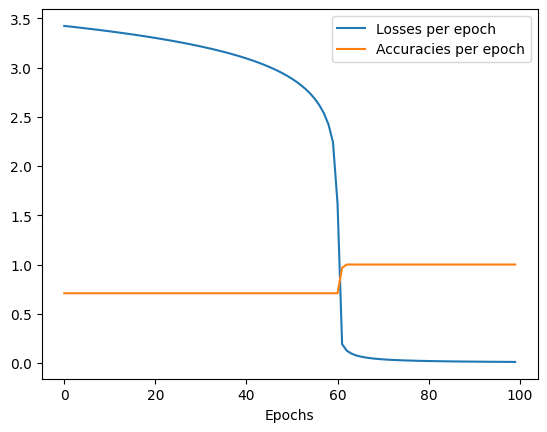

In [397]:
from iris import train

net = MLP(4, [1])
net.train(train['data'], train['target'], learning_rate=0.1, batch_size=8, epochs=100)

Test

In [398]:
from iris import test


predictions = net.forward(test['data'])
hits = np.count_nonzero((predictions >
                  0.5).astype(int) == test['target'])
hits / len(test['target'])

1.0